In [7]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [8]:
%matplotlib inline

# Простая линейная регрессия

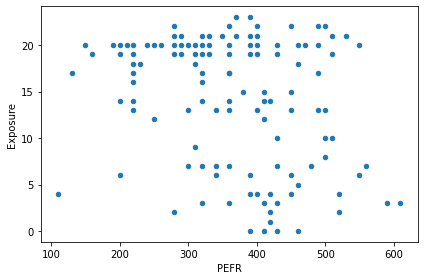

In [9]:
lung = pd.read_csv('/Users/ivankudravcev/Studying/Data/Lung.csv', sep=';')

lung.plot.scatter(x='PEFR', y='Exposure')

plt.tight_layout() # Adjust the padding between and around subplots.
plt.show()

Исользуем модель `LinearRegression` из библиотеки _scikit-learn_.

In [10]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


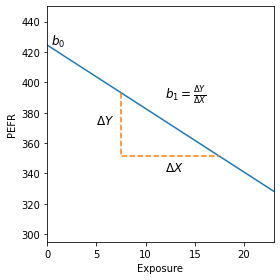

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = pd.DataFrame({'Exposure': [7.5, 17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--', color='C1')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')

ax.text(12, y[1]-10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

## Подогнанные значения и остатки (fitted values & residuals)
Метод `predict()` подогнанной при помощи _scikit_learn_ модели может использоваться для прогнозирования
новых точек данных.

In [12]:
fitted = model.predict(lung[predictors]) # подогнанные значения
residuals = lung[outcome]-fitted # вычисление остатков

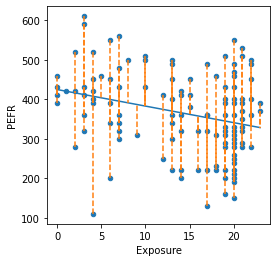

In [13]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

Остатки - длины пунктирных линий

# Множественная линейная регрессия

In [14]:
house = pd.read_csv('/Users/ivankudravcev/Studying/Data/house.csv', sep=';')

subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
0      300805.0           2400     9373       3.00         6          7
1     1076162.0           3764    20156       3.75         4         10
2      761805.0           2060    26036       1.75         4          8
3      442065.0           3200     8618       3.75         5          7
4      297065.0           1720     8620       1.75         4          7


In [15]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']

outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print()
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f'{name}:\t{coef}')

Intercept: -521871.368

Coefficients:
SqFtTotLiving:	228.83060360240796
SqFtLot:	-0.06046682065307607
Bathrooms:	-19442.840398321056
Bedrooms:	-47769.95518521438
BldgGrade:	106106.96307898083


### Оценка модели
_Scikit-learn_ предоставляет возможность расчитать некоторые метрики для оценки модели.
Здесь использованы оценки `R-squared` и `RMSE (root mean squared error)`.

In [16]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)

print(f'RMSE = {RMSE:.2f}')
print(f'R^2 ={r2:.2f}')


RMSE = 261220.20
R^2 =0.54


В то время как _scikit-learn_ дает возможность расчета множества разных метрик, _statsmodels_ обеспечивает более глубинный анализ регрессионной модели. Этот пакет имеет два разных способа описания модели - первый похож на _scikit-learn_, а второй позволяет задавать формулы в стиле _R_. Ниже используется первый вариант.
Т.к. _statsmodels_ не добавляет пересечение автоматически, необходимо добавить столбец констант со значением "1" к списку _predictors_. Сделать это можно применив метод `assign()` из пакета _Pandas_.

In [17]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        20:18:54   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

### Выбор модели и пошаговая регрессия
Для включения в модель категориальных и булевых переменных, в _Python_, их необходимо преобразовать в числовые значения.
Для преобразования можно использовать метод `get_dummies()` и `list comprehensions`.

In [18]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        20:18:56   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

Добавление переменных в модель всегда уменьшает `RMSE` и увеличивает `R-squared` => это не лучшие критерии для оценки модели.
Метрики `adjusted R-squared (скорректированный R^2)` и `AIC (Akaike's Information Criteria)` учитывают количество метрик. Цель состоит в том, чтобы максимизировать `adj. R-squared` и минимизировать `AIC`.

##### Этого можно добиться:
#####    1) Перебрать все подмножества предикторов (вычислительно затратно на больших данных) - `регрессия всех подмножеств`. Либо начать с полной модели и последовательно отбрасывать переменные, которые не вносят вклад - `обратное устранение`.
#####    2) Начать с константной модели, а затем последовательно добавлять переменные - `прямой отбор`
#####    3) Последовательно добавлять и отбрасывать предсказатели.

Эти функции имплиментируются в пакете `dmba` (stepwise_selection, forward_selection и backward_elimination)


In [19]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201884
 BldgGrade: 137159.56022619773
 YrBuilt: -3565.4249392492993
 Bedrooms: -51947.38367361318
 Bathrooms: 42396.164527717796
 PropertyType_Townhouse: 84479.16203300405
 SqFtFinBasement: 7.046974967553979
 PropertyType_Single Family: 22912.055187017682


### Взвешенная регрессия

Можно вычислить Год из колонки DocumentDate используя `List comprehensions` или метод _DataFrame_ `apply()`.

In [20]:
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
0,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
1,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
2,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
3,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
4,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


Более свежие записи являются более весомыми,  вес = год записи - наименьший год (2005). Таким образом формируется 
колонка с весами для каждой записи.

In [21]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year-2005

В большинстве моделей _scikit-learn_ вес задается парметром `sample_weight` метода `fit()`

In [22]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

pd.concat([
    pd.DataFrame({
        'Predictor' : predictors,
        'house_lm' : house_lm.coef_,
        'house_wt' : house_wt.coef_
    }),
    pd.DataFrame({
        'Predictor' : ['Intercept'],
        'house_lm' : house_lm.intercept_,
        'house_wt' : house_wt.intercept_
    })
])

,Predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,Intercept,-521871.368188,-584189.329446


Видно, что коэффициенты во взвешенной регрессии немного отличаются. Анализ остатков:

   abs_residual_lm  abs_residual_wt  Year
0    123750.814194    107108.553965  2014
1     59145.413089     96191.882094  2006
2    190108.725716    187004.492880  2007
3    198788.774412    196132.996857  2008
4     91774.996129     84277.577512  2013



,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


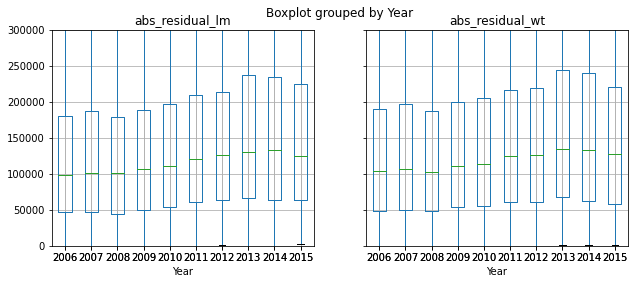

In [23]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
print()
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

### Факторные переменные в регрессии
В данных присутствует факторная переменная PropertyType с 3 уровнями: Multiplex, Single Family и Townhouse.
Ее необходимо преобразовать, т.к. `регрессия требует на входе числовые данные`.

In [24]:
house.PropertyType.head(6)

0        Multiplex
1    Single Family
2    Single Family
3    Single Family
4    Single Family
5        Townhouse
Name: PropertyType, dtype: object

Преобразование переменной PropertyType: при помощи метода `get_dummies()` cоздаются фиктивные (dummies) двоичные переменные. Такой способ кодирования называется `one hot encoder`. Этот способ широко применяется в машинном обучении. Здесь сохранены все 3 фактора.

In [25]:
print(pd.get_dummies(house['PropertyType']).head(6))

   Multiplex  Single Family  Townhouse
0          1              0          0
1          0              1          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              0          1


Однако, регрессия требует преобразовать факторную переменную с `P` факторами в `P-1` фиктивную переменную для избежания  мультиколлинеарности. Для этого в методе `get_dummies()` указывается параметр `drop_first=True`, который исключает первый столбец среди фиктивных переменных (этот столбец м.б. вычислен из предыдущих)

In [26]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

   Single Family  Townhouse
0              0          0
1              1          0
2              1          0
3              1          0
4              1          0
5              0          1


In [27]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)
house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Пересечение: {house_lm_factor.intercept_:.4f}')
print()
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f'{name}:\t{coef:.4f}')


Пересечение: -446841.3663

SqFtTotLiving:	223.3736
SqFtLot:	-0.0704
Bathrooms:	-15979.0135
Bedrooms:	-50889.7322
BldgGrade:	109416.3052
PropertyType_Single Family:	-84678.2163
PropertyType_Townhouse:	-115121.9792


### Факторные переменные с множеством уровней

`ZipCode` - факторная переменная с множеством уровней

In [28]:
pd.DataFrame(house['ZipCode'].value_counts()).transpose()

,98038,98103,98042,98115,98117,98052,98034,98033,98059,98074,...,98051,98024,98354,98050,98057,98288,98224,98068,98113,98043
ZipCode,788,671,641,620,619,614,575,517,513,502,...,32,31,9,7,4,4,3,1,1,1


Модель `house_lm` имеет 5 степеней свободы, в то время как 80 значений переменной `ZipCode` имеет 79 степеней свободы. Более того несколько почтовых индексов имеют всего 1 продажу. В некоторых задачах можно консолидировать данные по первым 2-3 значениям, но в данном случае все продажи соответствуют индексам 980xx или 981xx и здесь такой подход не поможет. Альтернативный подход - группирование почтовых индексов с использованием еще одной переменной, такой как продажная цена. Еще лучше сгруппировать индексы используя остатки из первоначальной модели:

In [29]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']

outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],       # колонка с индексами
        'residuals': house[outcome]-house_lm.predict(house[predictors]) # колонка с остатками
    })
    .groupby(['ZipCode']) #группируем по индексам, записываем количество записей и медиану остатков в группе
    .apply(lambda x: {
        'ZipCode': x.iloc[0, 0],
        'count': len(x),
        'median_residual': x.residuals.median()
    })
]).sort_values('median_residual') # сортируем по медианам остатков

zip_groups['cum_count'] = np.cumsum(zip_groups['count']) # колонка с совокупной суммой
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False) # разбиваем на 5 групп по квантилям колонки совокупной суммы 

print(zip_groups.ZipGroup.value_counts().sort_index())

0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


In [30]:
# Добавляем колонку с указанием группы индекса к основным данным

to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,Year,Weight,ZipGroup
0,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,1991,0,0,70000,229000,98002,False,2014,9,2
1,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,2005,0,0,203000,590000,98166,True,2006,1,2
2,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1947,0,0,183000,275000,98166,False,2007,2,2
3,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,1966,0,0,104000,229000,98168,False,2008,3,2
4,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1948,0,0,104000,205000,98168,False,2013,8,2


### Коррелированные переменные
Коэффициент модели `best_model` - `Bedrooms` отрицательный и из этого следует, что добавление спальни уменьшает стоимость дома, что не логично.

In [31]:
print(f'Пересечение: {best_model.intercept_:.3f}') 
print()
print('Коэффициенты:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}:\t{coef:.3f}')

Пересечение: 6178645.017

Коэффициенты:
 SqFtTotLiving:	199.278
 BldgGrade:	137159.560
 YrBuilt:	-3565.425
 Bedrooms:	-51947.384
 Bathrooms:	42396.165
 PropertyType_Townhouse:	84479.162
 SqFtFinBasement:	7.047
 PropertyType_Single Family:	22912.055


Это вызвано тем, что предсказательные переменные коррелированы. Переменные для спален, размера дома и числа ванных комнат — все они являются коррелированными, т.к. косвенно характеризуют размер дома (т.е. существует линейная зависимость: например, чем больше спален, тем больше дом).
`Удалим` переменные `SqFtTotLiving` (жилая площадь), `SqFtFinBasement` (цокольная площадь) и `Bathrooms` (ванные комнаты) из уравнения:

In [32]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])

print(f'Пересечение: {reduced_lm.intercept_:.3f}')
print()
print('Коэффициенты:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f'{name}:\t{coef:.3f}')

Пересечение: 4913973.344

Коэффициенты:
Bedrooms:	27150.537
BldgGrade:	248997.794
YrBuilt:	-3211.745
PropertyType_Single Family:	-19898.495
PropertyType_Townhouse:	-47355.437


### Искажающие переменные
Искажающие переменные `(confounding variables)` - важные переменные, не включенные в модель. В данном случае `ZipGroup`:

In [33]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']

outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Пересечение: {confounding_lm.intercept_:.3f}')
print()
print('Коэффициенты:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f'{name}:\t{coef:.3f}')


Пересечение: -666637.469

Коэффициенты:
SqFtTotLiving:	210.613
SqFtLot:	0.455
Bathrooms:	5928.426
Bedrooms:	-41682.872
BldgGrade:	98541.184
PropertyType_Single Family:	19323.625
PropertyType_Townhouse:	-78198.721
ZipGroup_1:	53317.173
ZipGroup_2:	116251.589
ZipGroup_3:	178360.532
ZipGroup_4:	338408.602


### Взаимодействия и основные эффекты
Основные эффекты - переменные включенные в модель. Взаимодествие между ними зачастую может оказывать существенный вклад в модель регрессии: например, между переменными `SqFtTotLiving` (площадь) и `ZipFroup` (местоположение). Пакет `statsmodels` позволяет задавать регрессионную модель в стиле `R` и взаимодейтсвие указывается при помощи символа `'*'`. 

In [34]:
model = smf.ols(formula = 'AdjSalePrice ~ SqFtTotLiving*ZipGroup + SqFtLot +' +
               'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        20:19:20   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

### Выбросы
Проведем анализ выбросов по записям, относящимся к индексу 98105. Используем для этого стандартизированные остатки (остатки деленные на их стандартную ошибку).

In [35]:
house_98105 = house[house['ZipCode']==98105]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']

outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], 
                       house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()

Используем класс `OLSInfluence` пакета `statsmodels`. Мы извлекаем стандартизированные остатки, используя метод `resid_studentized_internal()` и находим индекс наименьшего:

In [36]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

20428 -4.326731804078561


In [37]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115824


Самая большая завышенная оценка из модели составляет более 4 стандартных ошибок над регрессионной прямой, что соответствует завышенной оценке в 757753$. Исходная запись в данных, которая соответствует этому выбросу:

In [38]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 20428, dtype: object


In [39]:
f1 = house_98105['SqFtTotLiving'] >= 2800
f2 = house_98105['SqFtTotLiving'] < 3000
filt = house_98105.loc[f1&f2]
filt[['SqFtTotLiving','AdjSalePrice']]

,SqFtTotLiving,AdjSalePrice
8391,2800,1031296.0
8393,2810,1048422.0
13495,2960,1020494.0
13500,2800,1250218.0
15250,2810,1424668.0
19114,2980,1036778.0
19597,2810,758669.0
20428,2900,119748.0
20467,2820,765348.0


В данном случае что-то не так с записью: дом такого размера обычно продается за большую цену, чем 119748 в этом индексе. Из установочного акта этой продажи ясно, что продажа предусматривала всего лишь долю в собственности. В этом случае выброс соответствует продаже, которая является аномальной и не должна быть включена в регрессию. СТандартизированные ошибки - способ искать аномалии в данных.

## Диагностика регрессии
### Влиятельные записи
Для наборов с большим количеством данных вряд ли какое-либо значение сможет повлиять на модель. Поэтому эта тем актуальна для малых наборов данных.
Влиятельные записи - те записи, которые существенно влияют на регрессионную прямую. Такие записи не обязательно ассоциируются с крупными остатками.
Ниже приведен пример как изменяется регрессионная прямая из-за одной записи.

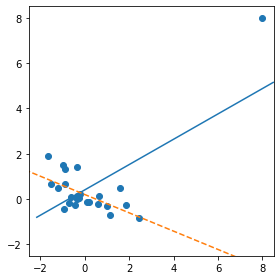

In [40]:
%matplotlib inline
from scipy.stats import  linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x/5+np.random.normal(size=25)

x[0]=8
y[0]=8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept+slope*x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

Считается, что такая запись имеет сильное плечо (рычаг). В дополнение к стандартизированным остаткам, существует еще ряд метрик для определения влиятельности:
о данных с высоким плечом говорят
`hat-значение` (значения выше 2(P+1)/n) и `Расстояние Кука` (если превышает 4/(n-P-1)).
График влиятельности или (пузырьковый график) объединяет стандартизированные остатки, hat-значение и расстояние Кука в одном графике.

Ось X - hat-значения.
Ось Y - остатки.
Размер пузырьков - расстояние Кука. (график см. ниже)

Также пузырьковые графики очень полезны для обнаружения аномалий.

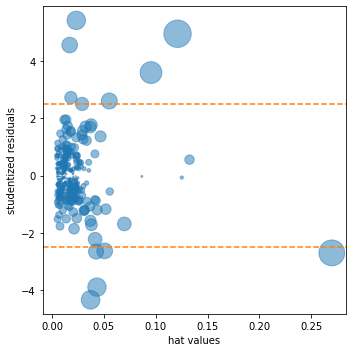

In [41]:
influence = OLSInfluence(result_98105)

fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
          s=1000*np.sqrt(influence.cooks_distance[0]),
          alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

Исключив записи, превышающие расстояние Кука равное 0.08, мы получаем другие коэффициенты. Наприме, теперь переменная `Bathrooms` имеет отрицательное значение - конечно это нелогично, но в данной модели не были учтены важные предикторы (такие как местоположение).

In [42]:
mask = [dist < 0.08 for dist in influence.cooks_distance[0]]

house_infl = house_98105.loc[mask]
ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


### Гетероскедастичность, ненормальность и коррелированные ошибки.
Нормально распределенные ошибки - признак что модель завершена; ошибки, которые не явл. нормально распределенными - признак того, что модель что-то упускает.

Ниже приведена гистограмма стандартизированных остатков для регрессии `result_98105`. Её расределение однозначно имеет более длинные хвосты, чем у нормального и демонстрирует умеренную ассиметричность в сторону более крупных остатков. 

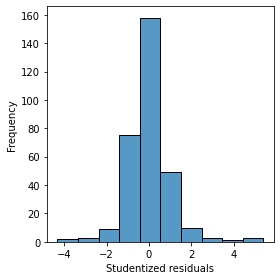

In [43]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.histplot(x=influence.resid_studentized_internal, bins=10, ax=ax)

plt.xlabel('Studentized residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

`Гетероскедастичность` - отсутствие постоянной остаточной дисперсии по всему диапазону предсказанных значений. Иными словами для некоторых частей диапазона ошибки больше, чем для других. 

В науке о данных первоочередным объектом явл. предсказательная точность, и поэтому анализ на гетероскедастичность не помешает - это поможет обнаружить, что в данных имеется некий сигнал, который модель не уловила.

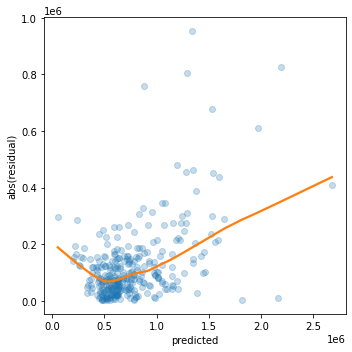

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid),
            scatter_kws={'alpha':0.25},
            line_kws={'color':'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

На графике видно, что дисперсия остатков имеет тренд на увеличение для домов с более высокой стоимостью и также является высокой для домов с низкой стоимостью. Приведенный график говорит о том, что регрессия `result_98105` имеет гетероскедастичные ошибки. Гетероскедастичность говорит о том, что регрессия что-то не учла в высоко и низкодиапазонных домах.

### Графики частных остатков и нелинейность
`Графики частных остатков` - это способ визуализации того, насколько хорошо вычисленная подгонка объясняет связь между предсказателем и исходом. Главная идея графика состоит в фокусировании на связи между предиктором и исходом, `принимая в расчет все предсказатели`. Частный остаток - значение, объединяющее предсказание на основе отдельного предсказателя с фактическим остатком от полного уравнения регресии, это оценка вклада, ктотрый прелсказатель вносит в продажную цену. Такой график можно создать используя библиотеку `statsmodels` и её метод `graphics.plot_ccpr()`

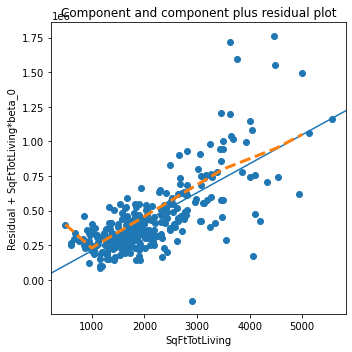

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

# Примерно построенная линия (как в книге)
x = [500, 1000, 3500, 4500, 5000]
y = [400000, 230000, 800000, 950000, 1050000]
ax.plot(x, y, '--', lw=3)

plt.tight_layout()
plt.show()

График демонстрирует то, что регрессионная прямая (синяя линия) недооценивает продажную цену для домов площадью менее 1000 кв. футов. Выше 4000 кв. футов имеется слишком мало точек данных, чтобы делать какие-то выводы. Оранжевый пунктир - сглаженная кривая частных остатков. Видно, что связь между предиктором `SqFtTotLiving` нелинейна и `следовательно вместо простого линейного члена SqFtTotLiving следует рассмотреть нелинейный член`.

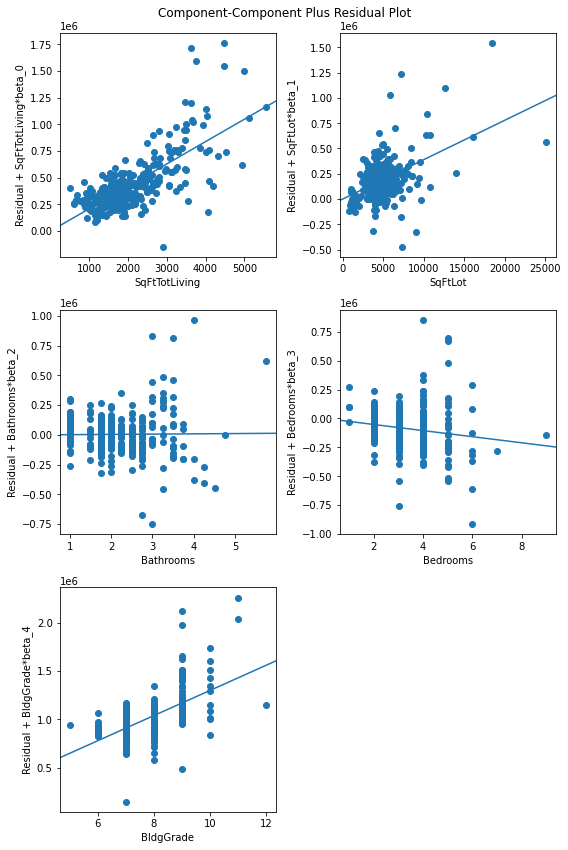

In [46]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

### Диагностика регрессии, выводы:
###### Хотя выбросы могут вызывать проблемы для малых наборов данных, первоочередной интерес к ним заключается в выявлении проблем с данными или в локализации аномалий.
###### Отдельные записи (включая регрессионные выбросы) могут оказывать бльшое влияние на уравнение регрессии с малыми данными, но этот эффект размывается в больших данных
###### Если регрессионная модель используется для формального статистического вывода (p-значение и т.п.), то д.б. проверены некоторые допущения о природе распределения остатков. В общем случае, распределение остатков не имеет критическую важность в науке о данных.
###### График частных остатков может использоваться для качественной диагностики подгонки для каждого члена регрессии, возможно приводя к альтернативной модели.

# Многочленная и сплайновая регрессия.
Связь между откликом и предсказателем не обязательно является линейной. Существует несколько способов, которыми регрессия м.б. расширена для получения нелинейных эффектов.
Модель нелинейной регрессии не может быть подогнанна с помощью наименьших квадратов.

### Многочлены
Многочленная регрессия предусматривает включение в состав уравнения полиномиальных членов. В пакете `statsmodels` квадратичный член добавляется так: `I(SqFtTotLiving**2)`:

In [47]:
model_poly = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving + ' +
                    '+ I(SqFtTotLiving**2) + ' +
                    'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())


                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Tue, 31 May 2022   Prob (F-statistic):          9.95e-106
Time:                        20:21:22   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -6.159e+

Теперь с переменной `SqFtTotLiving` связано 2 коэффициента: один для линейного члена, другой - для квадратного. График частных остатков говорит о некоторой кривизне в уравнении регрессии, связаннос с переменной `SqFtTotLiving`. Подогнанная линия более точно соответствует сглаженной кривой частных остатков по сравнению с линейной подгонкой.
Имплементация в  библиотеке `statsmodels` для графика частных остатков работает только для линейных членов. Ниже приведена имплементация графика частных остатков, который работает с полиномной (многочленной) регрессией:

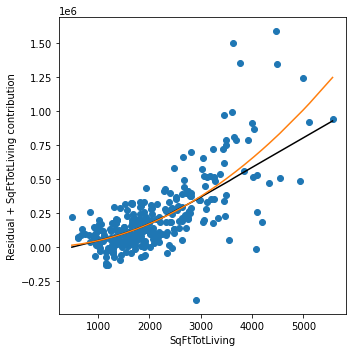

0.038791281682311475


In [48]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c==feature:
            continue
        copy_df[c] = 0.0 # all columns = 0.0 except feature
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome]-y_pred,
        'ypartial': feature_prediction - model.params[0]   # model.params[0] - interception value
    })  
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature,  frac =1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color = 'black')
    ax.plot(results.feature, results.ypartial, color='C1')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])


На графике частотных остатков - многочленная регрессия , подогнанная  для переменной `SqFtTotLiving` (оранж. линия) против сглаженной кривой (черная линия). См. далее про сплайны.

### Сплайны
Многочленная регрессия захватывает только некоторый объем кривизны в нелинейной связи. Добавление членов более высоких степеней, таких как куб, часто приводит к нежелательной "волнистости" в уравнении регрессии. Альтернативный и часто превосходящий подход к моделированию нелинейных связей состоит в использовании `сплайнов`. Библиотека `statsmodels` содержит метод `bs()` для создания B-сплайнового члена в регрессионной модели. Здесь необходимо определить степень многочлена и местоположение узлов. 

In [49]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' +
          'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Tue, 31 May 2022   Prob (F-statistic):          7.10e-104
Time:                        20:21:25   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


В данном случае предсказатель `SqFtTotLiving` включается в модель с использованием кубического сплайна (degree=3). Здесь мы указываем B-сплайн, используя `df` (степени свободы). Создалось `df-степень=6-3=3` внутренних узла с позициями на границах, в нижнем квартиле, медиане и верхнем квартиле.

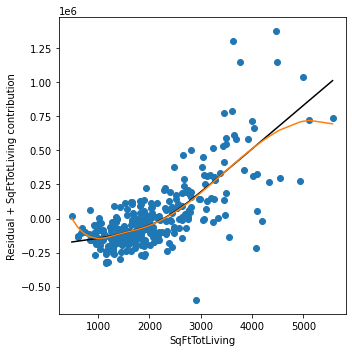

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

В отличие от полиномной модели, сплайновая модель намного ближе подходитк сглаженной кривой. В данном случае линия подогнана к данным намного точнее. Но это не обязательно означает, что сплайновая регрессия явл. более оптимальной моделью. С экономической точки зрения нет никакого смысла в том, чтобы дома менее 1000 кв. футов имели более высокую стоимость, чем дома немного крупнее. Возможно, это артефакт искажающей переменной.

### Обобщенные аддитивные модели (Generalized additive models)
Полиномиальные члены могут быть недостаточно гибкими для улавливания связи, а сплайновые члены требуют указывать узлы. 
`Обобщенные аддитивные модели (Generalized additive models, GAM)` - это гибкий прием моделирования, предназначенный для автоматической подгонки сплайновой регрессии. 
В `Python` содержится пакет  `pyGAM `. Он предоставляет регресионные и классификационные методы. В данном примере использован класс `LinearGAM` для создания регрессионной модели:

In [51]:

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)

print(gam.summary())


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1676
                                                Scale:                                    29480381715.8292
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

/var/folders/26/6n64wy9s3v9bjxfzjrrwndyh0000gn/T/ipykernel_61398/2627059156.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


Модель `GAM` имеет большое множество  нелинейных коэффициентов, поэтому их сложно интерпретировать. Помогает в этом - визуализация.

`.generate_X_grid()` - задает разрешение линии (насколько тонко он её будет прорисовывать)

`.partial_dependence()` - считает значения самой линии + доверительный интервал

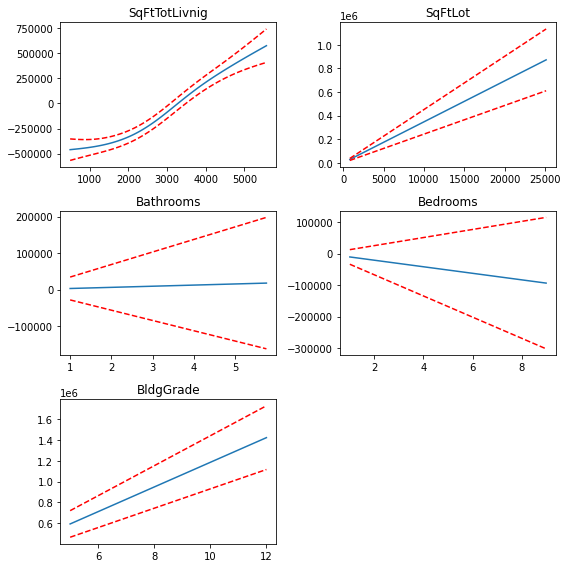

In [52]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLivnig', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

for i, title in enumerate(titles):
    ax = axes[i//2, i%2]
    XX = gam.generate_X_grid(term=i) # задаем разрешение для конкретного предиктора (по умолчанию n=100)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX)) #term - номер предиктора (term=0 - выбрать 1 предиктор)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--') # width - знач. доверит. интервала
    ax.set_title(titles[i])

axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

https://www.youtube.com/watch?v=kWipfZhBpE0
45 min

## Регуляризация
### Лассо

In [70]:
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

In [71]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
0      300805.0           2400     9373       3.00         6          7
1     1076162.0           3764    20156       3.75         4         10
2      761805.0           2060    26036       1.75         4          8
3      442065.0           3200     8618       3.75         5          7
4      297065.0           1720     8620       1.75         4          7


In [72]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
columns = X.columns
# X = StandardScaler().fit_transform(X * 1.0)
y = house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

LinearRegression()


In [73]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

Lasso(alpha=10)


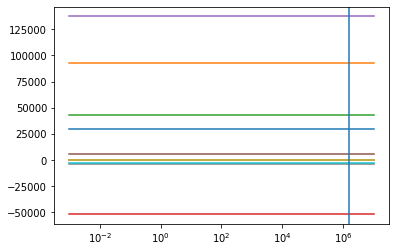

In [83]:
Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
results = []
for alpha in alpha_values:
     results.append(house_lm.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()


In [80]:
pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})

,name,coef
0,SqFtTotLiving,289.048846
1,SqFtLot,0.029471
2,Bathrooms,0.000000
3,Bedrooms,-0.000000
4,BldgGrade,0.000000
5,NbrLivingUnits,-0.000000
6,SqFtFinBasement,3.316479
7,YrBuilt,-0.000000
8,YrRenovated,45.727472
9,NewConstruction,-0.000000


In [81]:
# Intercept: 6177658.144
# Coefficients:
#  SqFtTotLiving: 199.27474217544048
#  BldgGrade: 137181.13724627026
#  YrBuilt: -3564.934870415041
#  Bedrooms: -51974.76845567939
#  Bathrooms: 42403.059999677665
#  PropertyType_Townhouse: 84378.9333363999
#  SqFtFinBasement: 7.032178917565108
#  PropertyType_Single Family: 22854.87954019308